### Gaussian Mixture Models

This notebook explores the theory of gaussian mixture models and some examples of their applications.

Suppose we have $k$ random variables $\{X_i | i = 1, \ldots, k\}$ with corresponding densities $p_i(x)dx$.

Given weights $w_1, \ldots, w_k$ that are positive and sum to 1 we define the mixture of the variables random variables as the random variable given by the distribution

$$
\sum_i w_i p_i(x) dx.
$$

In the case when all the random variables are gaussian we call the mixture a gaussian mixture model (gmm).

In [36]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import norm, uniform

from IPython.core.pylabtools import figsize; figsize(9, 6)

In [108]:
class GMM(object):
    
    def __init__(self, parameters, weights):
        assert len(weights) == len(parameters)
        assert abs(sum(weights) - 1.0) < 1e-8
        self.weights = np.array(weights)
        self.parameters = np.array(parameters)
        
    def pdf(self, x):
        return np.dot(
            self.weights,
            np.apply_along_axis(
                lambda p: norm.pdf(x, *p),
                1,
                self.parameters
            )
        )
    
    def pdf_data(self, points=np.linspace(-1.0, 1.0, 1000)):
        return pd.Series(
            np.apply_along_axis(self.pdf, 0, points),
            index=points
        )
    
    def plot(self, points=np.linspace(-1.0, 1.0, 1000), **kwargs):
        data = self.pdf_data(points)        
        data.plot(**kwargs)
        
    def samples(self, N):
        # split the N into the weighted components
        split = [int(N * weight) for weight in self.weights]
        # rounding errors (we just make add to the final one)
        split[-1] += N - sum(split)
        assert sum(split) == N
        samples = []
        
        for (n, params) in zip(split, self.parameters):
            samples += list(norm.rvs(size=n, loc=params[0], scale=params[1]))
        return np.array(samples)

In [127]:
gmm = GMM([[0.0, 1.0], [0.8, 0.2], [2.4, 0.7]], [0.25, 0.15, 0.6])

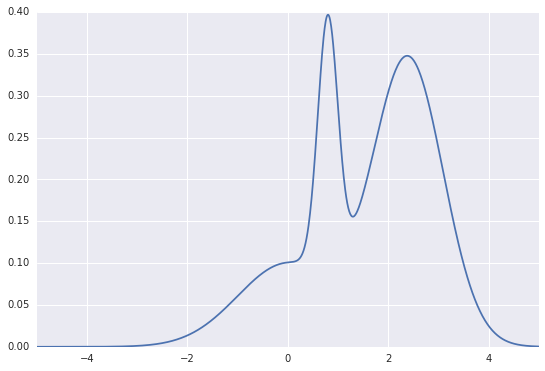

In [33]:
gmm.plot(points=np.linspace(-5.0, 5.0, 1000))

### Fitting GMMs

The next thing we are interested in is fitting GMMs to some data set. There are 3rd party libraries that provide the implementations which we will use in the future but let us begin by explaining the EM algorithm.

#### EM algorithm

The update state of the algorithm looks like:

Let $p(i|x) = \frac{w_i N(x|\lambda_i, \sigma_i)}{\sum_j w_j N(x|\lambda_j, \sigma_j)}$ denote the probability that the sample $x$ is of type $i$ gven the current state.

1. Update the weights by 
$$w_i \mapsto \frac{1}{T} \sum_t p(i|x_t)$$
2. Update the means by
$$\lambda_i \mapsto \frac{\sum_t p(i|x_t) x_t}{\sum_s p(i|x_s)}$$
3. Update the covariance by
$$\sigma^2_i \mapsto \frac{\sum_t p(i|x_t) (x_t - \lambda_i) (x_t - \lambda_i)^T}{\sum_s p(i|x_s)}$$

Note that either step 2 or 3 can be skipped if one is not interested in updating either the mean or the variance for a given distribution.

In [155]:
class StoppingCondition(object):
    
    def __init__(self, max_iterations=500, max_diff=1e-6):
        self.max_iterations = max_iterations
        self.max_diff = max_diff
        
        self.iterations = 0
        self.max_diff_seen = False
        
    @property
    def stop(self):
        return self.iterations > self.max_iterations or\
            self.max_diff_seen
        
    def on_step(self, old_values, new_values):
        self.max_diff_seen =np.max(np.array(old_values) - np.array(new_values)) < self.max_diff
        self.iterations += 1
        

def one_dimension_fit(k, samples, stopping_condition=None):
    total_samples = len(samples)
    weights, means, variances = generate_initial_data(k, samples)
    results = list()
    stopping_condition = stopping_condition or StoppingCondition()
    
    while not stopping_condition.stop:
        wm0 = np.zeros(k)
        wm1 = np.zeros(k)
        wm2 = np.zeros(k)
        
        for sample in samples:
            likelihood_x = np.array(
                [norm.pdf(sample, l, v ** 0.5) for (l, v) in zip(means, variances)]
            )
            
            prob_given_x = weights * likelihood_x / np.dot(weights, likelihood_x)
            
            wm0 += prob_given_x
            wm1 += prob_given_x * sample
            wm2 += prob_given_x * sample ** 2
        
        new_weights = wm0 / total_samples
        # Due to rounding errors normalise the weights
        new_weights /= sum(new_weights)
        new_means = wm1 / wm0
        new_variances = wm2 / wm0 - np.power(new_means, 2)
        
        stopping_condition.on_step((weights, means, variances), (new_weights, new_means, new_variances))
        
        weights, means, variances = new_weights, new_means, new_variances
        
        results.append(
            GMM(
                list(zip(means, np.power(variances, 0.5))),
                weights
            )
        )
        
    return results

def generate_initial_data(k, samples):
    w = np.array([1.0 / k] * k)
    
    min_s, max_s = min(samples), max(samples)
    m = np.linspace(min_s, max_s, k)
    
    v = np.ones(k)
    
    return w, m, v

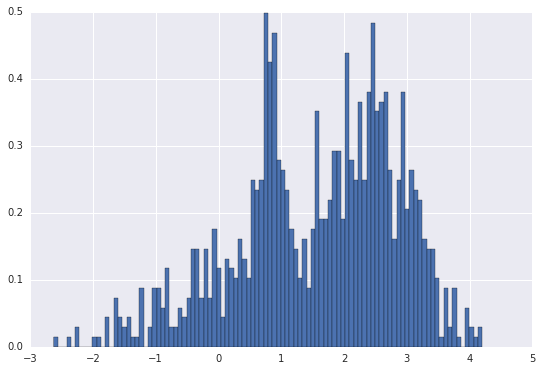

In [124]:
samples = gmm.samples(1000)

pd.Series(samples).hist(bins=100, normed=True)

In [158]:
# First let us run the fit against the samples with 1, 2, and 3 models.
f1 = one_dimension_fit(1, samples,)
f2 = one_dimension_fit(2, samples,)
f3 = one_dimension_fit(3, samples,)

In [138]:
# Let's now plot the final results
def plot_gmms(gmms, points, **kwargs):
    pd.DataFrame({k: gmm.pdf_data(points) for k, gmm in gmms.items()}).plot(**kwargs)
    
def plot_weights(gmms, range_=None, **kwargs):
    range_ = range_ or range(0, len(gmms))
    pd.DataFrame(
        [gmms[i].weights for i in range_],
        index=range_
    ).plot(**kwargs)

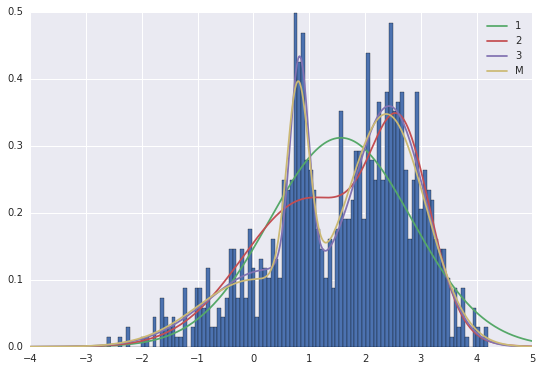

In [159]:
ax = pd.Series(samples).hist(bins=100, normed=True)

plot_gmms({'1': f1[-1], '2': f2[-1], '3': f3[-1], 'M': gmm}, np.linspace(-4, 5, 1000), ax=ax)

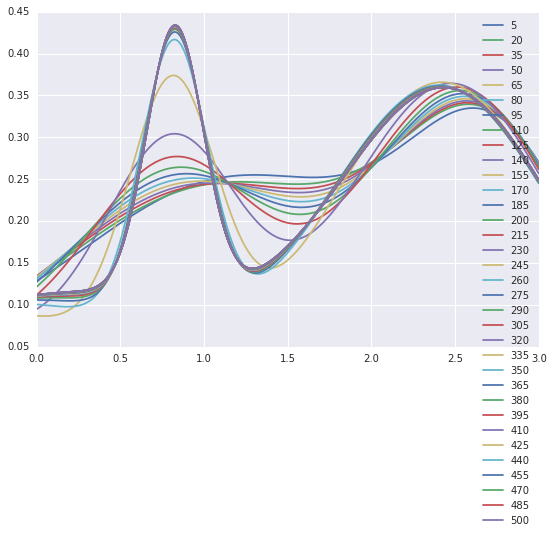

In [162]:
plot_gmms({i: f3[i] for i in range(5, len(f3), 15)}, np.linspace(0, 3, 1000))

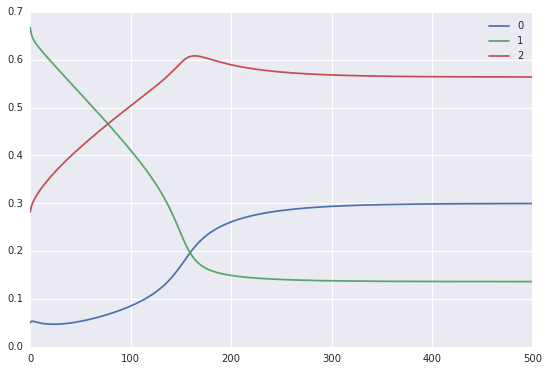

In [164]:
plot_weights(f3)

In [176]:
print(
"""
Model \t\t\t\t\tFit
----- \t\t\t\t\t---
{0}\t\t\t{1}
{2}
""".format(gmm.weights, f3[-1].weights,
           '\n'.join(['{0}\t\t\t\t{1}'.format(x, y) for (x, y) in zip(gmm.parameters, f3[-1].parameters)])))


Model 					Fit
----- 					---
[ 0.25  0.15  0.6 ]			[ 0.29959208  0.13629467  0.56411324]
[ 0.  1.]				[ 0.22502552  1.04683001]
[ 0.8  0.2]				[ 0.82741048  0.168467  ]
[ 2.4  0.7]				[ 2.46073967  0.64755509]



### Model selection

So what model selection criteria should we use? The most standard choice would be something along the lines of AIC or BIC. We shall now explain how we generate such information criteria for GMMs.

(Note model selection criteria is still an interesting research area for GMMs)

We shall begin by looking at the BIC and use scklearn module as well

In [177]:
from sklearn import mixture

In [181]:
gmm = mixture.GMM(3, n_iter=1)
gmm.means_ = np.array([[0], [0.8], [2.4]])
gmm.covars_ = np.array([[1], [0.2], [0.7]]) ** 2
gmm.weights_ = np.array([0.25, 0.15, 0.6])

In [182]:
sample = gmm.sample(1000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020F9B7090B8>]], dtype=object)

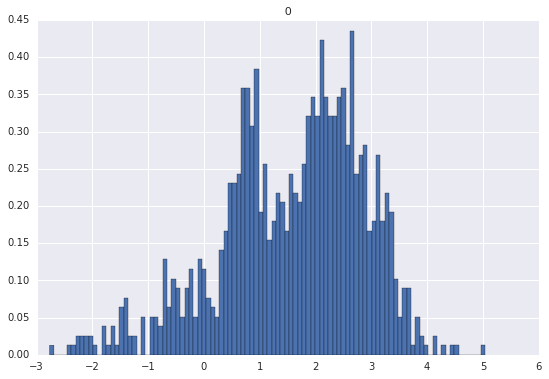

In [186]:
pd.DataFrame(sample).hist(bins=100, normed=True)

In [232]:
component_range = range(1, 7)

results = {'M': gmm}
for k in component_range:
    gmm_ = mixture.GMM(n_components=k)
    gmm_.fit(sample)
    results[k] = gmm_

In [230]:
def pdf(gmm, points=np.linspace(-4, 4, 1000)):
    return pd.Series(
        [
            np.dot(
                [
                    norm.pdf(x, l[0], v[0] ** 0.5) for (l, v) in zip(gmm.means_, gmm.covars_)
                ],
                gmm.weights_) for x in points
        ],
                       index=points)

def plot_gmms(gmms, points=np.linspace(-4, 4, 1000), **kwargs):
    pd.DataFrame({k: pdf(gmm_) for k, gmm_ in gmms.items()}).plot(**kwargs)

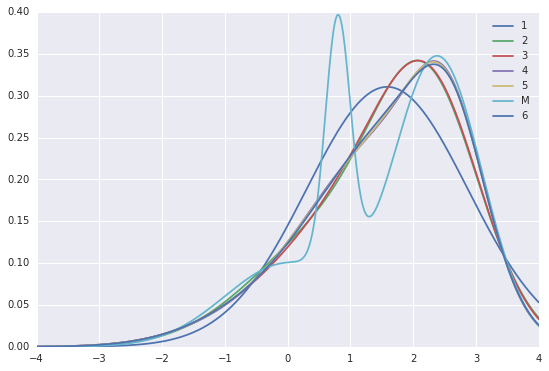

In [233]:
plot_gmms(results)